# **CPA attack on chosen Firmware (ANN) deployed on chipwhisperer**

## **1. Setup**


---



### *1.-1. Interactive Plot setup*


---

In [2]:
!pip install ipython ipympl ipywidgets -Uq
!pip install --upgrade ipython -Uq

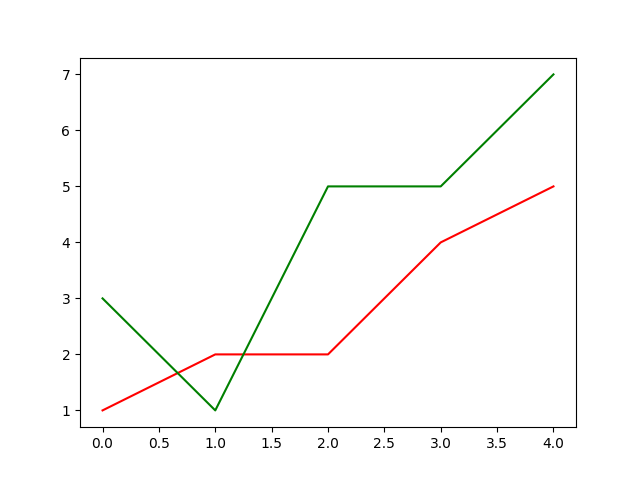

In [4]:
%matplotlib ipympl
import matplotlib.pylab as plt
    
plt.plot([1,2,2,4,5], 'r')
plt.plot([3,1,5,5,7], 'g')
plt.show()

### *1.0. Variables Setup*


---



- Defining several importatn variables, alongside relative target's paths

In [2]:
SCOPETYPE = 'OPENADC'                                                            # Scope type ...
hadware_dir = '../../../'                                                        # path to the imported /hardware/victims/firmware folder

MAKEDIR = './makefile_dir_2/'                                                    # Makefile folder relative path
CRYPTO_TARGET = './'                                            # Crypto target folder
FIRMWAREPATH = f'{hadware_dir}hardware/victims/firmware'                         # Firmware path, path to compiler, simpleserial of chipwhisperer

PLATFORM = 'CWLITEARM'                                                           # Chipwhisperer device type/Platform
SS_VER='SS_VER_2_1'                                                              # SimpleSerial version, in this case version 2
TARGET='simpleserial-target'                                                     # Target name, in this case simpleserial-target

### *1.1. ChipWhisperer Setup*


---



- Running additional ipynb file, containing basic setup of chipwhisperer, conditional of SETUP_VARS

In [3]:
import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.dis()
except:
    scope = cw.scope()
setup_ipynb = "../Setup_Scripts/Setup_Generic.ipynb"
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


Note to self:
When the scope is created, the device's green LED light starts blinking (on top of the blue LED that probably indicates that the device is connected physically).

We also set the scope to a default setup which means:

- Sets the scope gain to 45dB
- Sets the scope to capture 5000 samples
- Sets the scope offset to 0 (aka it will begin capturing as soon as it is triggered)
- Sets the scope trigger to rising edge
- Outputs a 7.37MHz clock to the target on HS2
- Clocks the scope ADC at 4*7.37MHz. Note that this is synchronous to the target clock on HS2
- Assigns GPIO1 as serial RX
- Assigns GPIO2 as serial TX

### *1.2. Firmware Setup*


---

- Running an bash program for translation of crypto target program, into format understandable by the device (.hex)
- There are several inputed vars, which are defined in 1.0. Variable Setup

In [4]:
%%bash -s "$MAKEDIR" "$CRYPTO_TARGET" "$PLATFORM" "$FIRMWAREPATH" "$SS_VER" "$TARGET"
cd $1
make CRYPTO_TARGET=$2 PLATFORM=$3 FIRMWAREPATH=$4 SS_VER=$5 TARGET=$6> output.txt 2>warnings.txt

### *1.3. Flashing The Compiled .hex Onto Target*


---




- This is an upload of crypto target software unto chipwhisperer, while it is in it's understandable format (.hex)

In [5]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, f"{MAKEDIR}simpleserial-target-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 17059 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 17059 bytes


- Reseting target for wholesome flushing

In [6]:
reset_target(scope)

## **2. Capture**

---

### *2.0. Capturing functions definitions*


---



In [1]:
from tqdm.notebook import trange
import random
import sys
import numpy as np

In [2]:
def scope_setup(samples=24431, decimate=2):
    # arm the scope
    scope.arm()
    # Set the maximum number of points in a trace
    scope.adc.fifo_fill_mode = "normal"
    scope.adc.samples = samples
    scope.adc.decimate = decimate
def capture_trace_of(trace_len, input_comp, scope):
    scope_setup(samples=trace_len, decimate=2)


    # flush the UART buffer
    target.flush()

    input_data = bytearray(input_comp * 16)
    target.send_cmd('p', 0x80, input_data)

    ret = scope.capture()
    trace = scope.get_last_trace()

    out_data = target.read_cmd('r')
    print(returned_data)
    ack = target.read_cmd('e')
    print(ack)
    trace = cw.Trace(wave, input_data, out_data, [])

    try:
        assert len(trace) == trace_len
        print("✔️ Trace is of targeted lenght!")
    except AssertionError as msg:
        print("❌ Trace is not of targeted lenght!")
    return trace


In [3]:
def createXSpecTraces(project_name = "lab1",num_traces = 1000, bnum = 8, input_size = 8): #create_X_traces_with_rand_Nth_bit
    project = cw.create_project(f"projects/{project_name}", overwrite = True)
    reset_target(scope)
    L = range((2**bnum)-1)
    rand_inputs = [random.choice(L) for _ in range(num_traces)]
    input_array = []
    for i in range(input_size):
        input_array.append(np.uint8(0))
    #sys.getsizeof(input_array)
    
    
    for i in trange(num_traces, desc='Capturing traces'):
        input_array[0] = np.uint8(rand_inputs[i])
        # print(input_array)
        scope_setup(samples=24431, decimate=2)
        # flush the UART buffer
        target.flush()
        input_data = bytearray(input_array)
        #print(f"Hello here is na input data: {input_data}")
        target.send_cmd('p', 0x80, input_data)
        ret = scope.capture()
        wave = scope.get_last_trace()
        out_data = target.read_cmd('r')
        ack = target.read_cmd('e')
        trace = cw.Trace(wave, input_data, out_data, [])
        #print(f"Hello here is na output data: {out_data}")
        if trace is None:
            print("None ....")
            returned_data
        project.traces.append(trace)
    
        #Send every 50th trace refress
        if i % 60 == 0:
            reset_target(scope)
        #if i % 3 == 0:
        #    #plot.send(trace)
        #    #Update interactive plot
        #    label_text = "line " + str(i)
        #    plt.plot(trace[0], label=label_text)
        #    plt.title(label_text)
        #    fig.canvas.draw()
    project.save()
    return project, out_data, rand_inputs

### *2.1. Capturing*

---



In [13]:
%run "../Helper_Scripts/plot.ipynb"
reset_target(scope)
#plot = real_time_plot(plot_len=25000)

#reset_target(scope)
#%matplotlib notebook
#import matplotlib.pylab as plt
#fig = plt.figure()
#plt.xlim([0, 5000])
#plt.ylim([-0.3, 0.2]) 

In [14]:
project, _out_data, _rand_inputs = createXSpecTraces(project_name = "lab_300_traces",num_traces=300)

Capturing traces:   0%|          | 0/300 [00:00<?, ?it/s]

In [16]:
import chipwhisperer as cw
proj = cw.open_project("projects/lab_300_traces.cwp")

In [15]:
print(f"Hello here is na input data: {_rand_inputs[49]}")
true_out = []
for i in range(3, len(_out_data) - 2):
    true_out.append(_out_data[i])
print(len(_out_data) - 2)
print(true_out) 

Hello here is na input data: 97
19
[31, 0, 0, 0, 0, 0, 0, 31, 31, 31, 31, 31, 31, 31, 31, 0]


### *2.2. After capture flushing*

---



- Afer all traces are accounted for run this block, it will disconnect from the device

In [17]:
scope.dis()
target.dis()

## **3. Analysis**

---



##### Imports

In [26]:
import chipwhisperer.analyzer as cwa
from scipy import stats

#### 3.0.1.1 Tool Functions

##### Math

In [5]:
def hamming_weight(x, is_int = True):
    if not is_int:
        return np.count_nonzero(x == 1)
    return bin(x).count("1")

In [6]:
def get_val_after_overflow(val = 0, bnum = 8):
    border = 2**(bnum-1)
    if val >= border:
        val = val % (border*2)
        if val >= border:
            val = -border + (val - border)
    return val

In [24]:
def mean(X = []):                             # EQ = np.mean(X, axis = 0)
   return (np.sum(X, axis=0)) / len(X)
def std_dev(X, mean, population = True):      # EQ = np.std(tra, axis = 0) 
    offset = 0
    if not population:
        offset = 1
        
    result = 0
    for  i  in  X:
        result += (i  - mean)**2
    result /= len(X) - offset
    return result**(1/2)
def cov(X, x_mean, Y, y_mean, population = True): # EQ = np.cov(X, Y, bias=True)
    if len(X) != len(Y):
        print("Arrays doesn't have same lenghts!!!")
        return

    offset = 0
    if not population:
        offset = 1
        
    result = 0
    for indx in range(len(X)):
        x = X[indx]
        y = Y[indx]
        result += (x  - x_mean) * (y  - y_mean)
    return result / (len(X) - offset)


#tra = [1,2,3,4,5]
#tro = [7,8,2,4,7]

#print(f"Mean: {mean(tra)}\n
#       Std_dev:{std_dev(tra, mean(tra))}\n
#       Cov: {cov(tra, mean(tra), tro, mean(tro))}\n
#       NP Mean: {np.mean(tra, axis = 0)}\n
#       NP Std_dev:{np.std(tra, axis = 0)}\n
#       NP Cov: {np.cov(tra, tro, bias=True)}")

In [8]:
def calc_corr(X, x_mean, Y, y_mean):
    cov_val = cov(X, x_mean, Y, y_mean)
    mult_stds = std_dev(X, x_mean) *  std_dev(Y, y_mean)
    return  cov_val / mult_stds

##### Trace

In [25]:
def normalize_trace(wave, treshold =  0.15):
    lenght =  len(wave)
    new_wave = np.ones((lenght,), dtype=int)
    for indx  in range(lenght):
        if abs(wave[indx]) < treshold:
            new_wave[indx] = 0
    return new_wave
# wave  = normalize_trace(project.traces[0][0], treshold = 0.05)
# plotSaveWave(wave = wave, name_wave = "temp_wave")

In [17]:
def uppSampleArray(origin_row, degree): # uppsample by  padding after every time sample
    exp_array = []
    for i in origin_row:
        exp_array.append(i)
        for ii in range (degree):
            exp_array.append(0)
    return exp_array

In [18]:
def write_read_csv(_array, cmd = 'w'):
    import pandas as pd 
    if cmd == 'w':
        df = pd.DataFrame(_array)
        df.to_csv("corr_all.csv")
    elif cmd == 'r':
        try:
            df = pandas.read_csv('corr_all.csv')
            df = df.iloc[: , 1:]
            df = df.fillna(0) 
        except NameError:
          print(f"Error {NameError} occured.")
          print(f"Most propably because the file was not found.")
# first_row = df.iloc[1, :].to_numpy(copy=True)
# df["Max_Row_Val"] = df.max( axis='columns' )
# df["Max_Row_Val_2"] = df.max(axis=0)
# df

#### 3.0.1.2 Weight Acquisition

In [33]:
def hyphothetical_leakage_calc(secret_interval = None, weight_bnum = 8, inputs = [0]):
    N_poss = 2**(weight_bnum-1)-1                                                  #calc number of possible secret key vals
    poss_secret_vals = []
    mult_results = []
    HW_guesses = []

    if secret_interval is None:                                                    #in case that i will want to input my own interval, such as -2 to 2, including -1.99, -1.98,...,1.98,1.99
        for offset in range(-N_poss, N_poss+1):                                    #generate all possible secret vals into an vector
            poss_secret_vals.append(offset)
        
    
    mult_results = np.outer(poss_secret_vals, inputs)                              #generate multiplication resuls of secret value and known input

    applyall = np.vectorize(hamming_weight)
    HW_guesses = applyall(mult_results)                                            #aply on generated matrix an Hamming weight calc function
    return HW_guesses, mult_results, poss_secret_vals 

# bnum = 8
# inputs = [1,3]
# HW, ___, ___ = hyphothetical_leakage_calc(weight_bnum = bnum, inputs = inputs)
def CPA_ANN(n_traces = 1000, waves = [cw.Trace[0]], bnum = 8, known_input = [0]):
    corr_all_secret = []
    HW, _, secre_weights = hyphothetical_leakage_calc(bnum, known_input)
    for i in range(2**bnum):
        HW_curr_secret = HW[i] #get HW vector, corresponding to current possible secret weight, and all rand inputs () 
        corr_curr_secret, _ = stats.pearsonr(HW_curr_secret, waves)
        corr_all_secret.append(abs(corr_curr_secret))
    return corr_all_secret

In [34]:
def V_CPA_ANN(n_traces = 1000, waves = [cw.Trace[0]], bnum = 8, known_input = [0], trace_len = 1):  #currently only for one wave corr_all_secret = []
    waves_n = []
    for i in waves:
        waves_n.append(normalize_trace(i, treshold = 0.05))
    L = []

    
    secret_weights = []
    M = 2**(bnum-1)
    for offset in range(-M, M):
        secret_weights.append(offset)

    
    corr_all_Tsamples = []
    for i in trange(M*2, desc='Calculating Correlations  for secret key:'): # For current WeightHyphothesis do
        corr_Tsamples = []
        H = [] #Hyphotheticalleakage
        for j in range(n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
            #print(f"i: {i} j:{j} len_i {len(secret_weights)} len_j {len(known_input)}")
            mult_result = secret_weights[i] * known_input[j]
            mult_result = get_val_after_overflow(mult_result) 
            H.append(hamming_weight(mult_result))
        H_mean = mean(H)

        # For current WeightHyphothesis, create an Correlation vector for each Hyphotheticalleakage (in other words for each trace): 
        for time_sample in range(trace_len):
            L = []
            curr_sample = time_sample * bnum
            for i in waves_n:
                L.append(hamming_weight(i[curr_sample:curr_sample+bnum], is_int = False))
            L_mean = mean(L)
            
            corr = calc_corr(H, H_mean, L, L_mean)
            corr_abs = abs(corr)
            corr_Tsamples.append(corr_abs)
        corr_all_Tsamples.append(corr_Tsamples)
            
    return corr_all_Tsamples

In [35]:
def V_ANN_CPA_OTS(n_traces = 1000, waves = [cw.Trace[0]], bnum = 8, known_input = [0], trace_len = 1): # Vanilla ANN CPA, for  one time_sample a 
    L = []
    
    secret_weights = []
    M = 2**(bnum-1)
    for offset in range(-M, M):
        secret_weights.append(offset)

    
    corr_all_Tsamples = []
    # wave_Blen = round(len(waves[0]))
    for i in trange(M*2, desc='Calculating Correlations  for secret key:'): # For current WeightHyphothesis do
        corr_Tsamples = []
        H = [] #Hyphotheticalleakage
        for j in range(n_traces):  #  Get an array of possible HammingWeights for current WeightHyphothesis (for all the traces)
            #print(f"i: {i} j:{j} len_i {len(secret_weights)} len_j {len(known_input)}")
            mult_result = secret_weights[i] * known_input[j]
            mult_result = get_val_after_overflow(mult_result) 
            H.append(hamming_weight(mult_result))
        H_mean = mean(H)

        # For current WeightHyphothesis, create an Correlation vector for each Hyphotheticalleakage (in other words for each trace): 
        for time_sample in range(trace_len):
            L = []
            curr_sample = time_sample * bnum
            for i in waves:
                L.append(i[time_sample])
            L_mean = mean(L)
            
            corr = calc_corr(H, H_mean, L, L_mean)
            corr_abs = abs(corr)
            corr_Tsamples.append(corr_abs)
        corr_all_Tsamples.append(corr_Tsamples)
            
    return corr_all_Tsamples


#waves = []
#for i in project.trace[0]:
    #waves.append(i)
#corr_all = V_ANN_CPA_OTS(n_traces = len(waves), waves = waves, known_input = _rand_inputs, trace_len = )

#### 3.0.1.1 NN CPA

In [32]:
def SCA_ANN_vanilla():
    raise NotImplementedError("Add your code here, and delete this.")

#### 3.0.1.1 Visualisation

In [ ]:
def createDiffWave(project):
    waves = []
    diff_waves = []
    square_waves = []
    
    for trace in project.traces:
        waves.append(trace[0])
    avg_wave = np.mean(waves,axis=0)
    
    for i in waves:
        diff_waves.append(np.subtract(i,avg_wave))
    for i in diff_waves:
        square_wave = []
        for ii in i:
            square_wave.append(ii**2)
        square_waves.append(square_wave)
    
    diff_avg = np.mean(diff_waves,axis=0)
    var = np.mean(square_waves,axis=0)

    
    return diff_avg, avg_wave, var, waves

#### 3.0.1 Functions Definitions


--- 

#### *3.0.2. First analysis for SPA plots* 

In [28]:
diff_avg, avg_wave, var, waves = createDiffWave(project)

In [49]:
import matplotlib.pyplot as plt
# Plot the trace
def plotSaveWave(linewidth=0.5, wave = [], name_wave = "wave"):
    #%matplotlib notebook
    fig = plt.figure()
    plt.plot(wave, linewidth=linewidth)
    plt.savefig(f'{name_wave}.svg', format='svg')
    plt.show()
    #plt.close()

In [30]:
cw.plot(avg_wave)

:Curve   [x]   (y)

In [31]:
cw.plot(diff_avg)

:Curve   [x]   (y)

In [32]:
cw.plot(avg_wave) * cw.plot(diff_avg)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

In [33]:
cw.plot(diff_avg - avg_wave)

:Curve   [x]   (y)

In [34]:
#cw.plot(project.traces[0][0] - avg_wave)

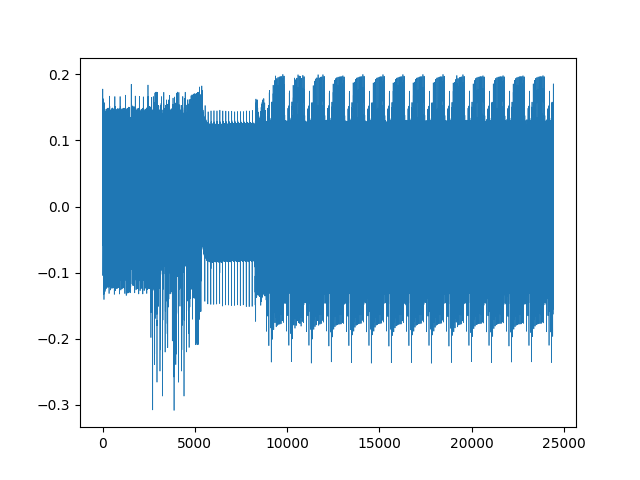

In [35]:
plotSaveWave(wave = avg_wave, name_wave = "avg_wave")

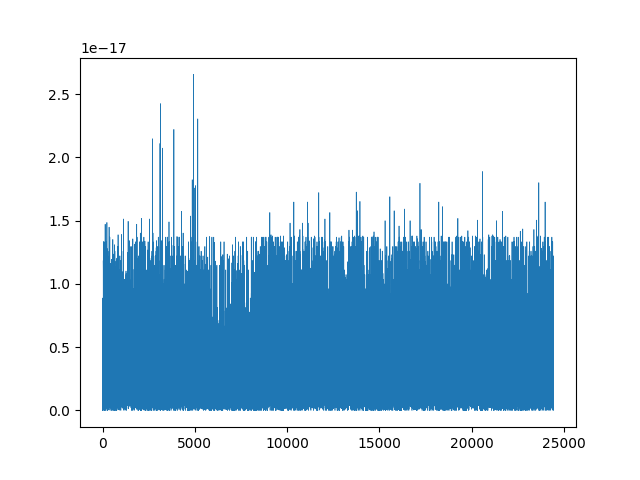

In [36]:
plotSaveWave(wave = abs(diff_avg), name_wave = "diff_avg")

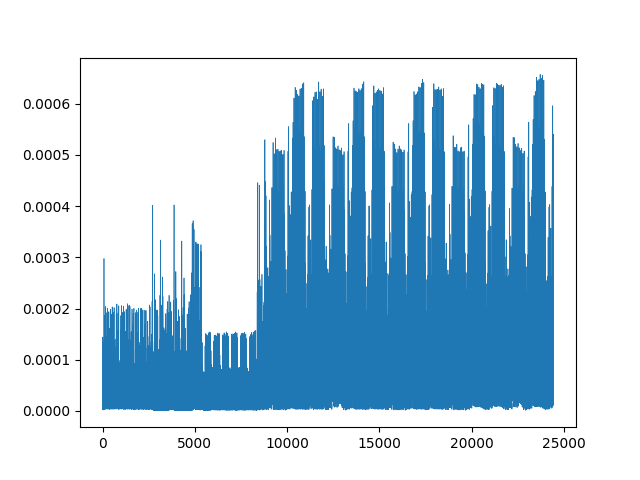

In [37]:
plotSaveWave(wave = var, name_wave = "var")

### *3.-1. Leakage model creation*


---



In [2]:
import chipwhisperer as cw
proj = cw.open_project("projects/lab_300_traces.cwp")

In [ ]:
class Config():
  def __init__(self, path = './drive/MyDrive/raw-img'):
    # Param. for chipwhisperer initialization
    self.chipwhisperer_init = {}
      
      
    #Model architecure
    self.architecture="CNN"
    self.classes=10
    self.path = path
    self.kernel_size: int  = 5
    self.kernelsCh: list = [6,12,24]
    self.padding: int = 2
    self.stride: list = 2
    self.pooling_size: int = 2
    self.fc_out: list = [512,256,128]
    # Data spec
    self.data_spec: dict = {
        "img_size": 128,
        "batch_size": 32,
        "data_path": path
    }
    self.sampler: torch.utils.data.sampler.WeightedRandomSampler

    # Training
    self.optim: torch.optim.Optimizer = SGD
    self.momentum: int = 0.4
    self.dropout: float = 0.01
    #self.optim_kwargs: dict = {"betas": (0.5, 0.999)}
    self.lr: float = 0.001
    self.epochs: int = 70
    self.num_workers: int = 2

        #def __init__(self, cnn_blocks=3, filters=16, kernel_size=(3,3), pool_size=(2,2), strides=2, drop_out=0.2, input_shape=(128, 128, 3), classes=10):
    self.cnn_blocks = 3,
    self.filters = 16,
    self.kernel_size = (3,3)
    self.pooling_size = (2,2)
    self.strides = 2
    self.dropout = 0.05
    self.input_shape = (128, 128, 3)
    self.lr = 0.001

## TODO

In [119]:
bnum = 16
rand_num = 1000
POSSIBILITIES = 2 ** bnum
possible_input_range = 256

possible_weights_interval = None
rand_input = random.randint(possible_input_range, size=(rand_num))
intermeadiate_guesses = None
HW_guesses = None

In [120]:
print(POSSIBILITIES)

65536


In [121]:
if possible_weights_interval is None:
    possible_weights_interval = []
    for offset in range(POSSIBILITIES):
        possible_weights_interval.append(offset)
if intermeadiate_quesses is None:
    intermeadiate_guesses = np.outer(possible_weights_interval[0:possible_input_range], possible_weights_interval)

In [122]:
applyall = np.vectorize(hamming_weight)
HW_guesses = applyall(intermeadiate_guesses)

In [124]:
HW_guesses = res

In [20]:
bnum = np.array([1,2,3,4])
we_q = np.array([1,2,3,4])

temp = np.outer(bnum,we_q)

print(temp)

[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]


In [4]:
class AES256_Round13_Model(cwa.AESLeakageHelper):
    def leakage(self, pt, ct, guess, bnum):
        # You must put YOUR recovered 14th round key here.
        # This example may not be accurate!
        calc_round_key = [0xea, 0x79, 0x79, 0x20, 0xc8, 0x71,
                          0x44, 0x7d, 0x46, 0x62, 0x5f, 0x51,
                          0x85, 0xc1, 0x3b, 0xcb]
        xored = [calc_round_key[i] ^ pt[i] for i in range(0, 16)]
        block = xored
        block = self.inv_shiftrows(block)
        block = self.inv_subbytes(block)
        block = self.inv_mixcolumns(block)
        block = self.inv_shiftrows(block)
        result = block
        return self.inv_sbox((result[bnum] ^ guess[bnum]))

class Quantized_ANN_Weight_Model():
    weight_quesses = None
    intermediate_quesses = None
    def leakage(self, guess, bnum): #bnum bite number, guess is an array of quesses
        if weight_quesses is None:
            temp_weight_guesses = []
            int weight_guess = 0
            for offset in range bnum ** 2:
                weight_guess += int(weight_guess + offset)offset
                temp_weight_guesses.append(hex(weight_quess))
            self.weight_quesses = temp_weight_guesses
        if intermediate_quesses is None:    
            self.intermediate_guesses = np.array(self.weight_quesses, input_integers)
        HW = [popcount_py(self.intermediate_guesses[known_input][i] for i in bnum**2])]
        return HW
        
    
    def popcount_py(x):
        return bin(x).count("1")

        
        #TODO return an array of HW(weight_j * input), which contains J weight guesses
        return hamming_weights

leak_model = cwa.leakage_models.new_model(Quantized_ANN_Weight_Model)

SyntaxError: invalid syntax (3013587290.py, line 23)

### *3.0. Trace preprocesing*

---



### *3.1. Analysis setup*

---



In [ ]:
import chipwhisperer.analyzer as cwa
#pick right leakage model for your attack
leak_model = cwa.leakage_models.new_model(ANN_Weight_Model)
attack = cwa.cpa(project, leak_model)
results = attack.run(cwa.get_jupyter_callback(attack))

### *3.2. LASCAR Quick Setup*

---



In [ ]:
import chipwhisperer.common.api.lascar as cw_lascar
from lascar import *
cw_container = cw_lascar.CWContainer(project, project.textins)
cpa_engines = [CpaEngine("cpa_%02d" % i, cw_lascar.sbox_HW_gen(i, range(256)) for i in range(16)]
session = Session(cw_container, engines=cpa_engines).run(batch_size=50)

### *3.3 Implementatio*

---



In [ ]:
import chipwhisperer.analyzer as cwa
disp = cw_lascar.LascarDisplay(cpa_engines, list(project.keys[0]))
disp.show_pge()